In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

file_path_raw = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_raw.csv"
file_path_per90 = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_per90.csv"
file_path_custom = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_custom_no_GK.csv"

data_raw = pd.read_csv(file_path_raw, encoding="utf-8")
data_per90 = pd.read_csv(file_path_per90, encoding="utf-8")
data_custom = pd.read_csv(file_path_custom, encoding="utf-8")
print(data_raw.columns)

Index(['equipe', 'player_id', 'player_name', 'player_country_code', 'age',
       'positions', 'matches_played', 'min', 'gls', 'ast',
       ...
       'second_yellow_cards', 'fls_com', 'fls_drawn', 'offside', 'pk_won',
       'pk_conceded', 'og', 'ball_recov', 'air_dual_won', 'air_dual_lost'],
      dtype='object', length=106)


### Pre-processing : remove non numeric columns, normalize as t-SNE (like ISOMap) is based on distances

In [17]:
def preprocessing(data):
    player_names = data['player_name']
    player_positions = data['positions']
    data_num = data.select_dtypes(include=[np.number]).dropna(axis=1, how='any')
    data_num.index = player_names
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_num)

    removed_cols = set(data.columns) - set(data_num.columns)
    print(f"Columns removed ({len(removed_cols)}): {sorted(list(removed_cols))}")
    
    return X_scaled, data_num.columns, player_positions

X_raw, cols_raw, player_positions_raw = preprocessing(data_raw)
X_per90, cols_per90, player_positions_per90 = preprocessing(data_per90)
X_custom, cols_custom, player_positions_custom = preprocessing(data_custom)

Columns removed (5): ['equipe', 'player_country_code', 'player_id', 'player_name', 'positions']
Columns removed (5): ['equipe', 'player_country_code', 'player_id', 'player_name', 'positions']
Columns removed (5): ['equipe', 'player_country_code', 'player_id', 'player_name', 'positions']


### t-SNE computation

In [24]:
def run_tsne(X, n_components, perplexity):
    tsne = TSNE(n_components= n_components, perplexity=perplexity, learning_rate=100, max_iter=3000, random_state=42)
    X_tsne = tsne.fit_transform(X)
    return X_tsne, tsne

X_tsne_raw, tsne_raw = run_tsne(X_raw, n_components=3, perplexity=10)
X_tsne_per90, tsne_per90 = run_tsne(X_per90, n_components=3, perplexity=10)
X_tsne_custom, tsne_custom = run_tsne(X_custom, n_components=3, perplexity=10)

### Results Display

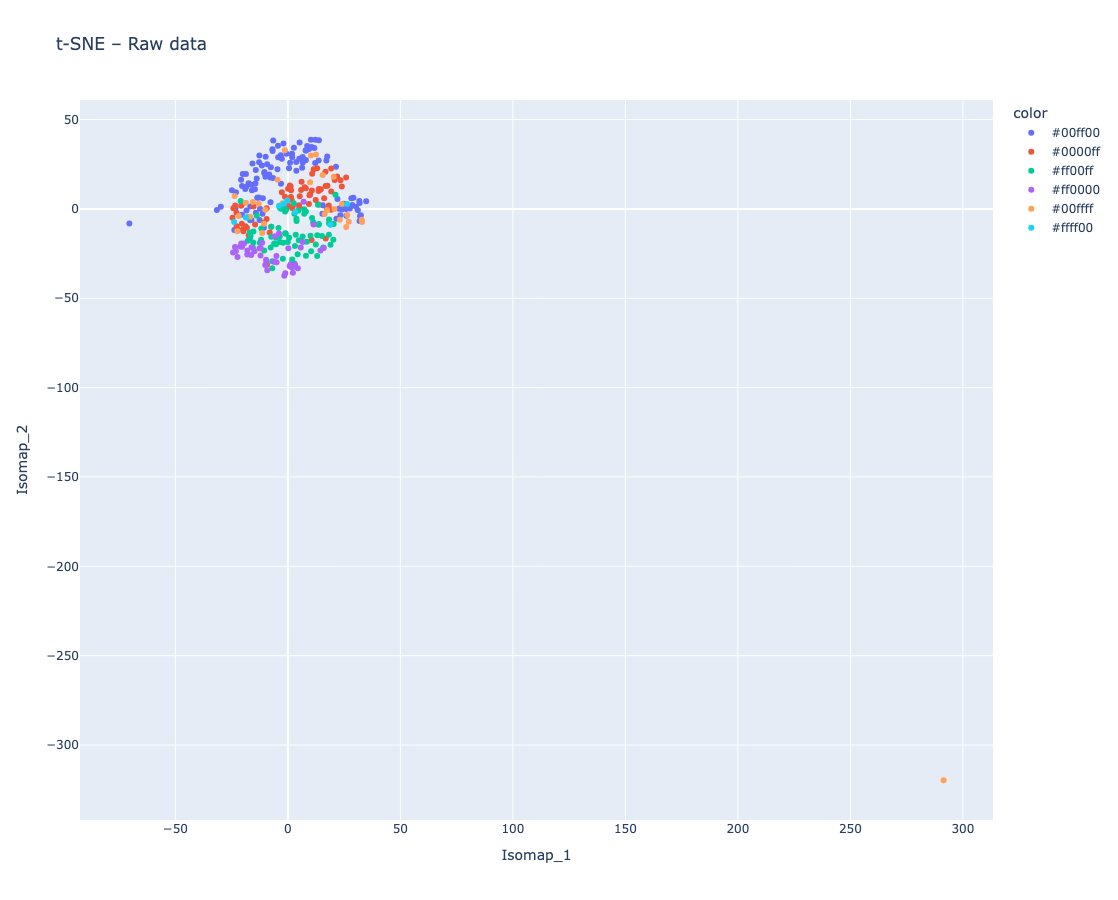

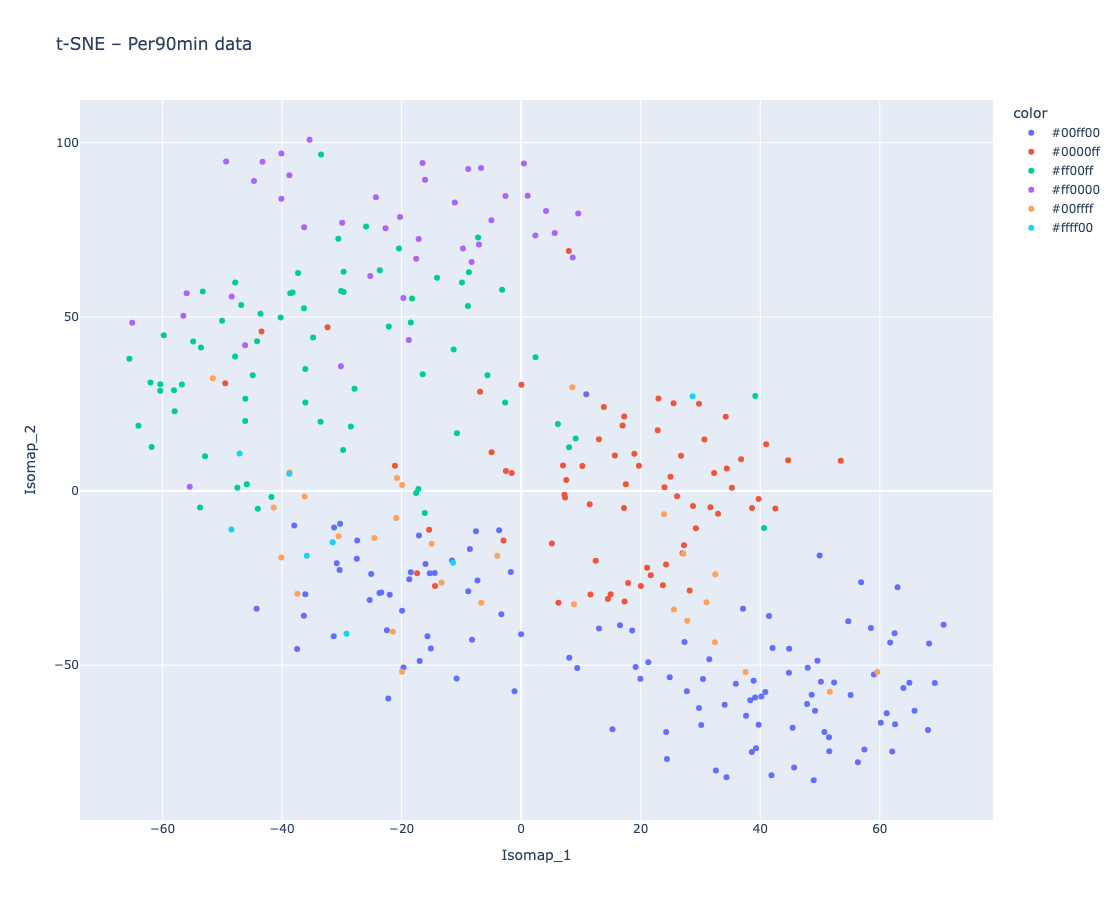

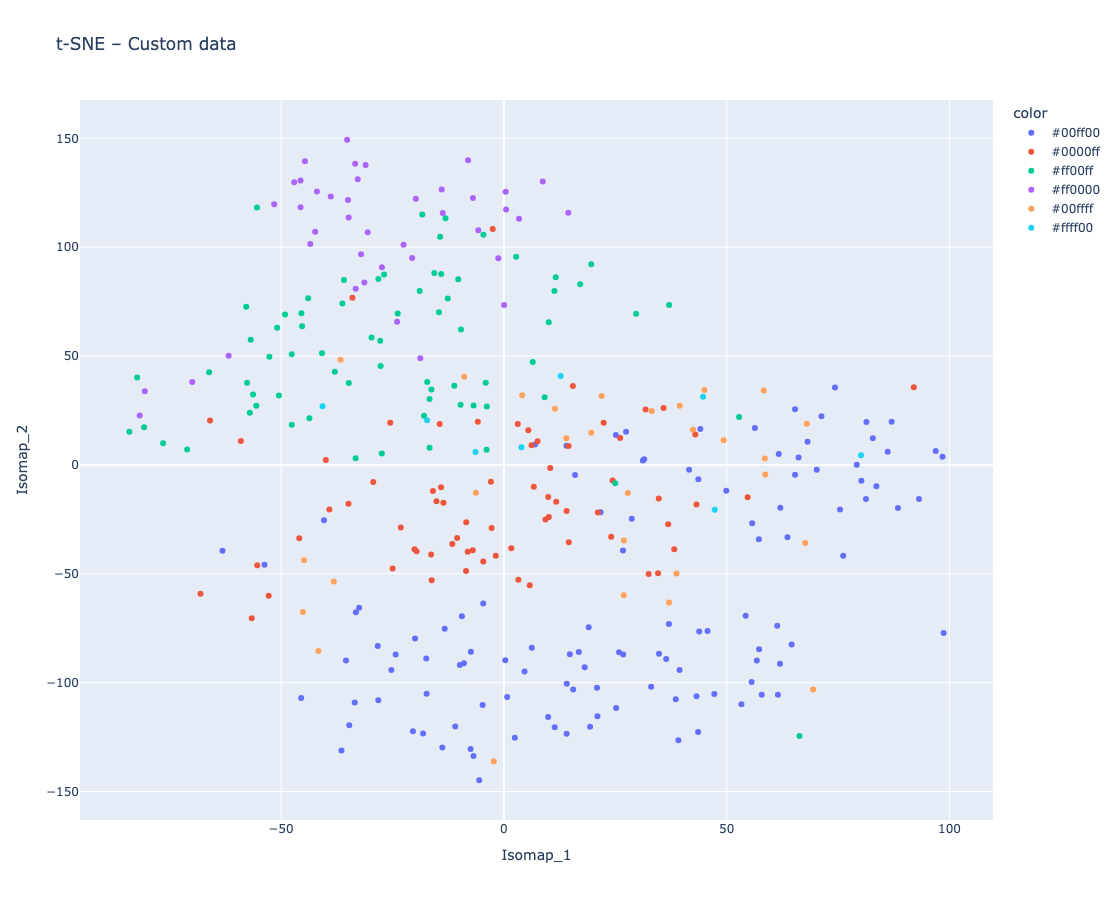

In [25]:
position_colors = {
    'FW': np.array([255, 0, 0]),    # red
    'MF': np.array([0, 0, 255]),    # blue
    'DF': np.array([0, 255, 0]),  #  yellow
}

def color_from_position(positions):
    postitions = str(positions)
    position_list = positions.split(',')
    colors = np.array([position_colors[p] for p in position_list if p in position_colors])
    avg_color = np.sum(colors, axis=0)
    return '#%02x%02x%02x' % tuple(avg_color.astype(int))

def plot_isomap_interactive(X_tsne, player_positions, data_num, title):
    df_plot = pd.DataFrame({
        'Isomap_1': X_tsne[:, 0],
        'Isomap_2': X_tsne[:, 1],
        'player_name': data_num.index,
        'color' : player_positions.apply(color_from_position)
    })
    
    fig = px.scatter(
        df_plot,
        x='Isomap_1', y='Isomap_2',
        hover_name='player_name',
        color='color',
        title=title,
        height=900, width=1100 
    )
    fig.show()

plot_isomap_interactive(X_tsne_raw, player_positions_raw ,data_raw.set_index("player_name"), "t-SNE – Raw data")
plot_isomap_interactive(X_tsne_per90, player_positions_per90 ,data_per90.set_index("player_name"), "t-SNE – Per90min data")
plot_isomap_interactive(X_tsne_custom, player_positions_custom ,data_custom.set_index("player_name"), "t-SNE – Custom data")

### t-SNE computation (more dimensions)

In [22]:
def run_tsne(X, n_components, perplexity):
    tsne = TSNE(n_components= n_components, perplexity=perplexity, learning_rate=100, max_iter=3000, random_state=42, method = "exact") #method "exact" as dim> 4
    X_tsne = tsne.fit_transform(X)
    return X_tsne, tsne

X_tsne_raw, tsne_raw = run_tsne(X_raw, n_components=10, perplexity=10)
X_tsne_per90, tsne_per90 = run_tsne(X_per90, n_components=10, perplexity=10)
X_tsne_custom, tsne_custom = run_tsne(X_custom, n_components=10, perplexity=10)

## t-SNE dim Reduction Export

In [9]:
def export_tsne(X_tsne, data, prefix):
    player_names = data['player_name']
    teams = data['equipe']
    positions = data['positions']

    tsne_df = pd.DataFrame(X_tsne, columns=[f'tsne_{i+1}' for i in range(X_tsne.shape[1])])
    
    tsne_df['player_name'] = player_names
    tsne_df['equipe'] = teams
    tsne_df['positions'] = positions
    
    filename = f"../../reduced_data/joueurs_ligue1_tSNE_{prefix}.csv"
    tsne_df.to_csv(filename, index=False, encoding="utf-8")
    print(f"✅ Exported {filename} ({tsne_df.shape[0]} rows, {tsne_df.shape[1]} columns)")

export_tsne(X_tsne_raw, data_raw, prefix='raw')
export_tsne(X_tsne_per90, data_per90, prefix='per90')
export_tsne(X_tsne_custom, data_custom, prefix='custom')

✅ Exported ../../reduced_data/joueurs_ligue1_tSNE_raw.csv (333 rows, 6 columns)
✅ Exported ../../reduced_data/joueurs_ligue1_tSNE_per90.csv (333 rows, 6 columns)
✅ Exported ../../reduced_data/joueurs_ligue1_tSNE_custom.csv (333 rows, 6 columns)


### Results Display - more dims

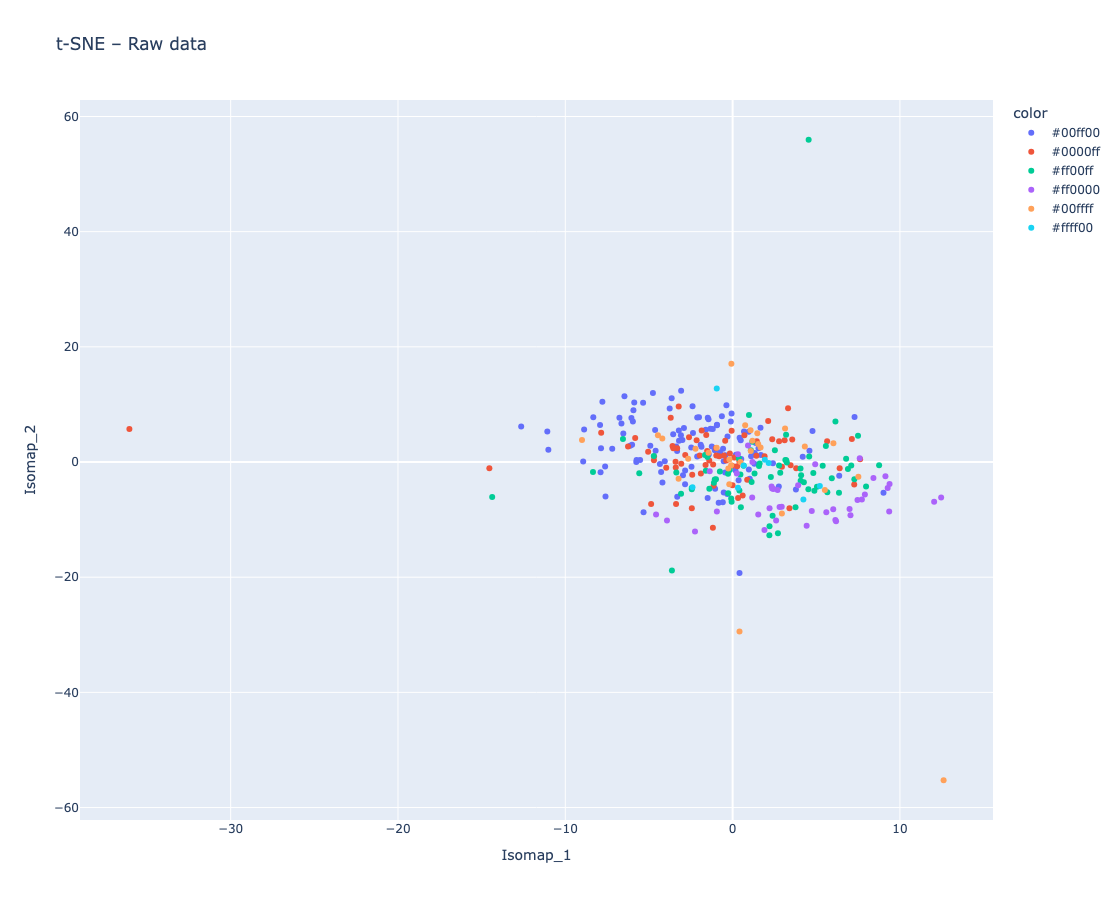

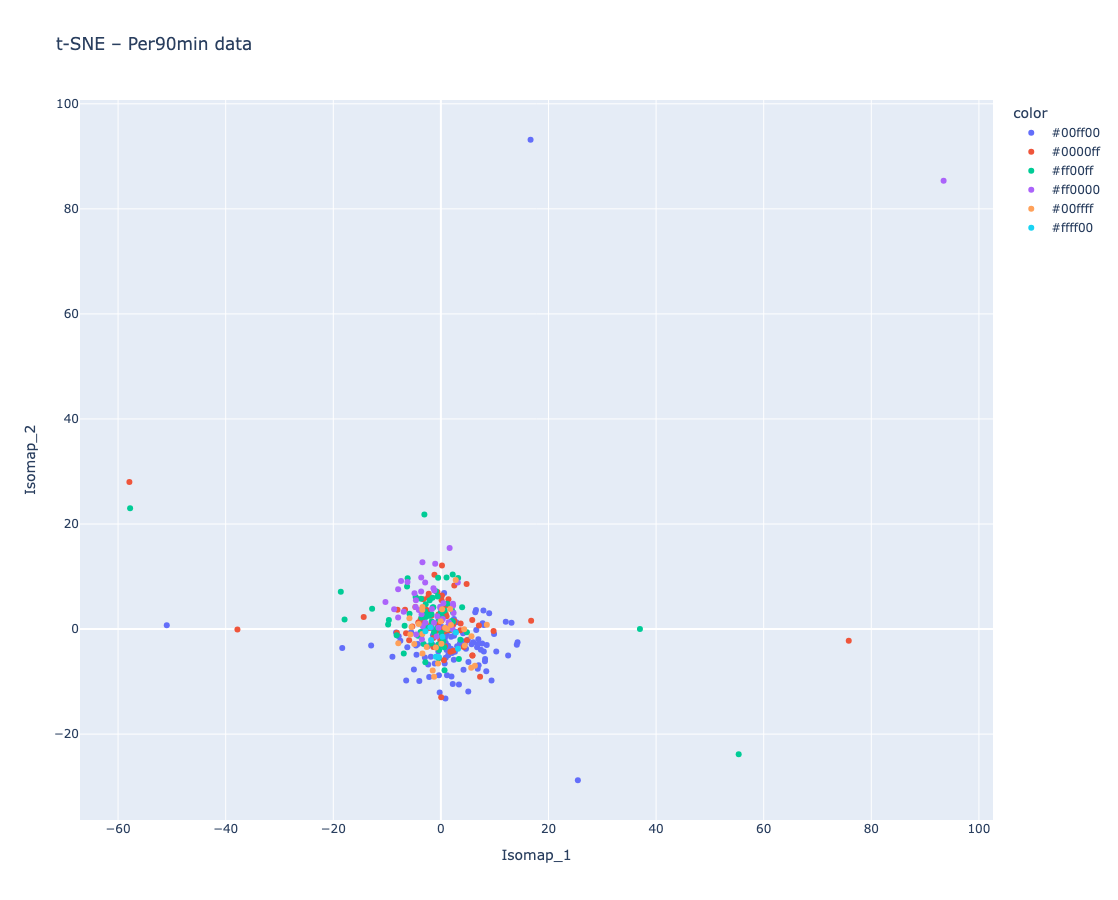

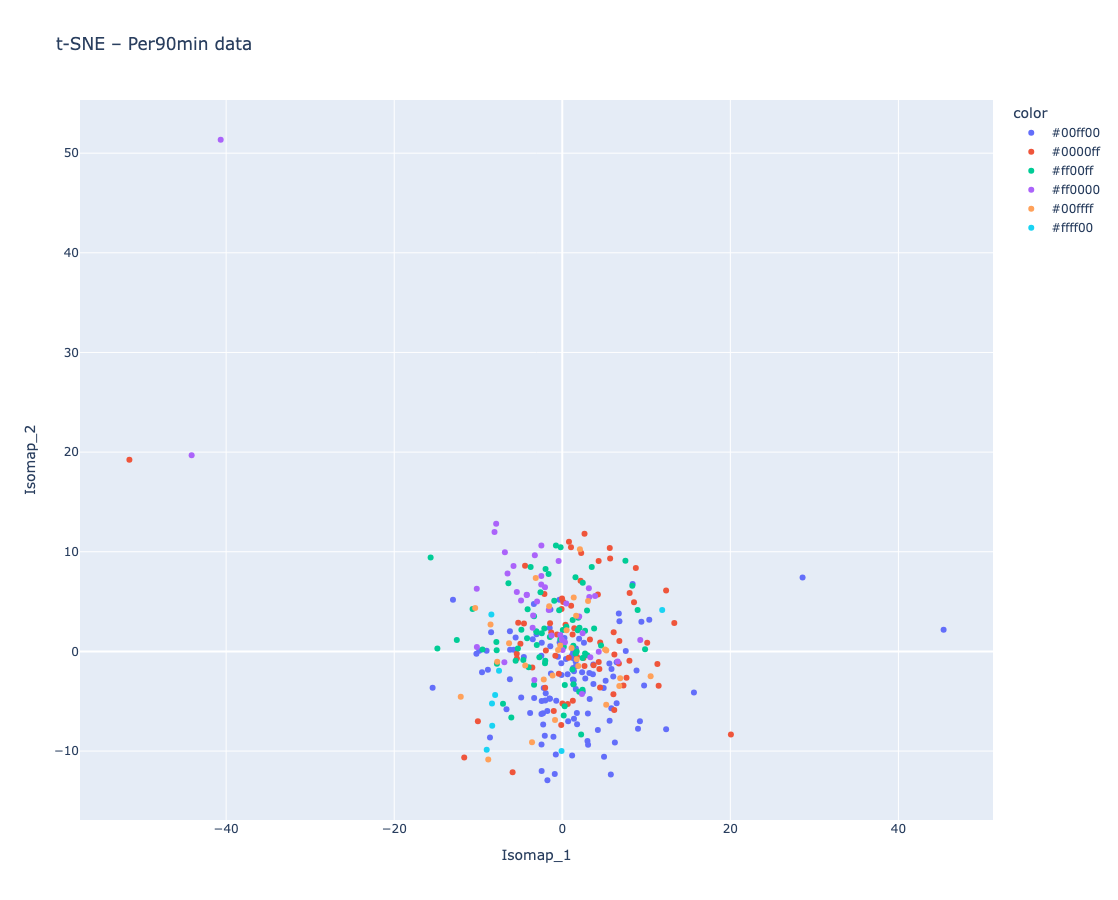

In [23]:
position_colors = {
    'FW': np.array([255, 0, 0]),    # red
    'MF': np.array([0, 0, 255]),    # blue
    'DF': np.array([0, 255, 0]),  #  yellow
}

def color_from_position(positions):
    postitions = str(positions)
    position_list = positions.split(',')
    colors = np.array([position_colors[p] for p in position_list if p in position_colors])
    avg_color = np.sum(colors, axis=0)
    return '#%02x%02x%02x' % tuple(avg_color.astype(int))

def plot_isomap_interactive(X_tsne, player_positions, data_num, title):
    df_plot = pd.DataFrame({
        'Isomap_1': X_tsne[:, 0],
        'Isomap_2': X_tsne[:, 1],
        'player_name': data_num.index,
        'color' : player_positions.apply(color_from_position)
    })
    
    fig = px.scatter(
        df_plot,
        x='Isomap_1', y='Isomap_2',
        hover_name='player_name',
        color='color',
        title=title,
        height=900, width=1100 
    )
    fig.show()

plot_isomap_interactive(X_tsne_raw, player_positions_raw ,data_raw.set_index("player_name"), "t-SNE – Raw data")
plot_isomap_interactive(X_tsne_per90, player_positions_per90 ,data_per90.set_index("player_name"), "t-SNE – Per90min data")
plot_isomap_interactive(X_tsne_custom, player_positions_custom ,data_custom.set_index("player_name"), "t-SNE – Per90min data")